# Sajad Hosseini Najafabadi
# 400301997

# 3.A

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
df_train = pd.read_csv('./data/Q3_train.csv')
df_test = pd.read_csv('./data/Q3_test.csv')

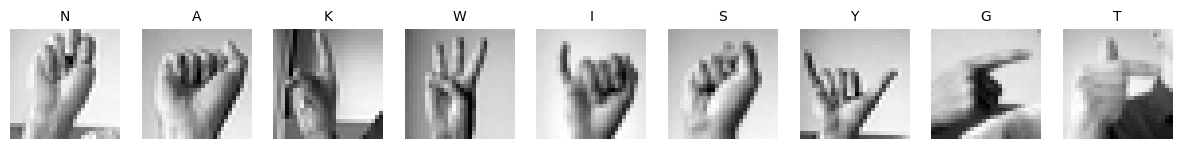

In [3]:
targets = {
            0: "A",
            1: "B",
            2: "C",
            3: "D",
            4: "E", 
            5: "F", 
            6: "G",
            7: "H",
            8: "I",
            9: "J",
            10: "K",
            11: "L",
            12: "M",
            13: "N",
            14: "O",
            15: "P",
            16: "Q",
            17: "R",
            18: "S",
            19: "T",
            20: "U",
            21: "V",
            22: "W",
            23: "X",
            24:"Y",
            25:"Z",
            }
fig, axs = plt.subplots(1, 9)
fig.set_figwidth(15)
for i in range(9):
    idx = torch.randint(1,len(df_train),(1,)).item()
    img = df_train.iloc[idx, 1:].to_numpy().reshape(28, 28)
    label = df_train.iloc[idx, 0]
    axs[i].set_title(f"{targets[label]}", fontsize=10)
    axs[i].imshow(img.squeeze(), cmap="gray")
    axs[i].axis(False)

# 3.B

In [4]:
train, validation = train_test_split(df_train, test_size=0.15)
X_train = torch.tensor(train.iloc[:,1:].values, dtype = torch.float32, device = device)
X_val = torch.tensor(validation.iloc[:,1:].values, dtype = torch.float32, device = device)
Y_train = torch.tensor(train.iloc[:,0].values, dtype = torch.int, device = device).long().squeeze()
Y_val = torch.tensor(validation.iloc[:,0].values, dtype = torch.int, device = device).long().squeeze()
X_test = torch.tensor(df_test.iloc[:,1:].values, dtype = torch.float32, device = device)
Y_test = torch.tensor(df_test.iloc[:,0].values, dtype = torch.int, device = device).long().squeeze()

In [5]:
class create_dataset(Dataset):
    
    def __init__(self, X, Y):
        self.dataset = X
        self.labels = Y
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx], self.labels[idx]

In [6]:
train_set = create_dataset(X_train, Y_train)
validation_set = create_dataset(X_val, Y_val)
test_set = create_dataset(X_test, Y_test)

In [7]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, drop_out_rate = 0):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=1024),
            nn.ReLU(),
            nn.Dropout(drop_out_rate),
            nn.Linear(in_features=1024, out_features=1024),
            nn.ReLU(),
            nn.Dropout(drop_out_rate),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU() ,
            nn.Linear(in_features=512, out_features=25),
        )
        
    def forward(self, x):
        return F.softmax(self.linear_relu_stack(x), dim = 1)

In [8]:
model = NeuralNetwork()
model = model.to(device)
model.train()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=25, bias=True)
  )
)

In [9]:
def train_loop(data, model, loss_fn, optimizer, batch_size):
    model.train()
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    for X, y in dataloader:
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"loss: {loss:>7f}")
            
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 100*correct

In [10]:
learning_rate = 1e-3
batch_size = 32
epoch = 20
loss_fn = nn.CrossEntropyLoss()
test_dataloader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)
validation_dataloader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)

# SGD

In [11]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_set, model, loss_fn, optimizer, batch_size)
    acc = test_loop(test_dataloader, model, loss_fn)
    if acc >= 75:
        break
print("Done!")

Epoch 1
-------------------------------
loss: 3.149747
Test Error: 
 Accuracy: 12.2%, Avg loss: 3.153019 

Epoch 2
-------------------------------
loss: 3.122736
Test Error: 
 Accuracy: 14.0%, Avg loss: 3.135208 

Epoch 3
-------------------------------
loss: 3.027147
Test Error: 
 Accuracy: 35.5%, Avg loss: 2.935971 

Epoch 4
-------------------------------
loss: 2.783120
Test Error: 
 Accuracy: 41.5%, Avg loss: 2.883255 

Epoch 5
-------------------------------
loss: 3.029649
Test Error: 
 Accuracy: 41.8%, Avg loss: 2.877757 

Epoch 6
-------------------------------
loss: 2.919260
Test Error: 
 Accuracy: 48.1%, Avg loss: 2.816229 

Epoch 7
-------------------------------
loss: 2.794233
Test Error: 
 Accuracy: 46.4%, Avg loss: 2.826507 

Epoch 8
-------------------------------
loss: 3.149787
Test Error: 
 Accuracy: 49.7%, Avg loss: 2.805858 

Epoch 9
-------------------------------
loss: 2.535277
Test Error: 
 Accuracy: 49.6%, Avg loss: 2.801911 

Epoch 10
----------------------------

# ADAM

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01*learning_rate, betas=(0.8, 0.8), eps=1e-08)

In [14]:
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_set, model, loss_fn, optimizer, batch_size)
    acc2 = test_loop(test_dataloader, model, loss_fn)
    if acc2 >= 75:
        break
print("Done!")

Epoch 1
-------------------------------
loss: 2.789528
Test Error: 
 Accuracy: 61.0%, Avg loss: 2.693984 

Epoch 2
-------------------------------
loss: 2.373625
Test Error: 
 Accuracy: 66.1%, Avg loss: 2.641125 

Epoch 3
-------------------------------
loss: 2.559368
Test Error: 
 Accuracy: 68.7%, Avg loss: 2.617039 

Epoch 4
-------------------------------
loss: 2.323561
Test Error: 
 Accuracy: 69.4%, Avg loss: 2.601969 

Epoch 5
-------------------------------
loss: 2.300865
Test Error: 
 Accuracy: 68.1%, Avg loss: 2.616891 

Epoch 6
-------------------------------
loss: 2.534694
Test Error: 
 Accuracy: 69.7%, Avg loss: 2.600008 

Epoch 7
-------------------------------
loss: 2.410655
Test Error: 
 Accuracy: 68.9%, Avg loss: 2.598600 

Epoch 8
-------------------------------
loss: 2.287250
Test Error: 
 Accuracy: 70.2%, Avg loss: 2.599590 

Epoch 9
-------------------------------
loss: 2.531199
Test Error: 
 Accuracy: 70.5%, Avg loss: 2.592097 

Epoch 10
----------------------------

###### Adam performs better than SGD. Because Adam has an adaptive learning rate Algorithm, helping it to converge faster.

# 3.C

In [15]:
model = NeuralNetwork(drop_out_rate = 0.2)
model = model.to(device)
model.train()

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=25, bias=True)
  )
)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01*learning_rate, betas=(0.8, 0.8), eps=1e-08)

In [17]:
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_set, model, loss_fn, optimizer, batch_size)
    acc3 = test_loop(test_dataloader, model, loss_fn)
    if acc3 >= 75:
        break
print("Done!")

Epoch 1
-------------------------------
loss: 2.948883
Test Error: 
 Accuracy: 10.3%, Avg loss: 3.180110 

Epoch 2
-------------------------------
loss: 3.142108
Test Error: 
 Accuracy: 18.7%, Avg loss: 3.096115 

Epoch 3
-------------------------------
loss: 3.031432
Test Error: 
 Accuracy: 23.8%, Avg loss: 3.047789 

Epoch 4
-------------------------------
loss: 3.030889
Test Error: 
 Accuracy: 28.3%, Avg loss: 3.006712 

Epoch 5
-------------------------------
loss: 2.782161
Test Error: 
 Accuracy: 33.3%, Avg loss: 2.961478 

Epoch 6
-------------------------------
loss: 2.695458
Test Error: 
 Accuracy: 33.4%, Avg loss: 2.952710 

Epoch 7
-------------------------------
loss: 2.790802
Test Error: 
 Accuracy: 34.6%, Avg loss: 2.941174 

Epoch 8
-------------------------------
loss: 2.904962
Test Error: 
 Accuracy: 35.4%, Avg loss: 2.931689 

Epoch 9
-------------------------------
loss: 2.542132
Test Error: 
 Accuracy: 37.3%, Avg loss: 2.908592 

Epoch 10
----------------------------

###### The convergence rate decreases with dropout, but it helps to reduce the test error and causes good generalization.
###### Because it adds a regularization part to the objective function.

# 3.D

In [19]:
print(f"Considering the limitation of 20 in the number of epochs, the best result was obtained in the Adam algorithm \n \
without dropout with {(acc2):>0.1f} % accuracy.")

Considering the limitation of 20 in the number of epochs, the best result was obtained in the Adam algorithm 
 without dropout with 75.7 % accuracy.
